In [1]:
database = [
    "Database/drive01", "Database/drive02",
    "Database/drive03", "Database/drive04",
    "Database/drive05", "Database/drive06",
    "Database/drive07", "Database/drive08",
    "Database/drive09", "Database/drive10",
    "Database/drive11", "Database/drive12",
    "Database/drive13", "Database/drive14",
    "Database/drive15", "Database/drive16",
    "Database/drive17a", "Database/drive17b",
]

In [2]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import scipy
import copy
import seaborn as sns

plt.style.use('ggplot')

In [3]:
def get_data(path="Database/drive01", channels=[0], sampfrom=0, sampto=500, hpf=True):
    sig, sinfo = wfdb.rdsamp(path, channels=channels, sampfrom=sampfrom, sampto=sampto)
    sig = sig.flatten()
    if hpf:
        sig = high_pass_filter(sig, sinfo["fs"])
    return sig, sinfo
def estimate_threshold(sig, percentile=92):
    return np.percentile(sig, percentile)
def find_peaks(sig, p=92):
    threshold = estimate_threshold(sig, p)
    peaks = []
    peak_values = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(sig):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                peak_values.append(current_peak_value)
                is_peak = False
    return np.array(peaks), np.array(peak_values)
def avg_hr(peaks, fs, signal_length):
    num_beats = len(peaks)
    duration_minutes = signal_length / (fs * 60.0)
    bpm = num_beats / duration_minutes
    return round(bpm, 1)
def high_pass_filter(sig, fs, cutoff_freq=50):
    # Calculate filter coefficients
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * fs))
    # Initialize filter variables
    y_prev = 0
    x_prev = 0
    # Apply high-pass filter
    filtered_signal = []
    for x in sig:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x
    return np.array(filtered_signal)
def test_peak_detection(file, sampfrom=0, nsamp=100000, correct_threshold=0.0001):
    samp, _ = wfdb.rdsamp(file, channels=None, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    ann = wfdb.rdann(file, extension="atr", sampfrom=sampfrom, sampto=sampfrom+nsamp)
    samp = samp[:, 0]
    peaks, _ = find_peaks(samp)
    threshold = correct_threshold
    total = ann.sample.size
    correct = 0
    wrong = 0
    for peak in peaks:
        detected = False
        for true_peak in ann.sample:
            delta = (true_peak+1) / (peak+1)
            deltap = np.abs(1-delta)
            if deltap < threshold:
                detected = True
                break

        if detected:
            correct += 1
        else:
            wrong += 1
    return correct, wrong, total, len(peaks)
def trim_to_peak(X, sr, fail=True):
    sr = int(sr)
    peaks, _ = find_peaks(X[:sr*2])
    if not peaks.any() and not fail:
        # If R peak not detected trim to max value in sr*2 interval
        imax = np.argmax(X[:sr*2])
        return X[imax:]
    elif not peaks.any() and fail:
        raise Exception("No peak detected")
    peak = peaks[0]
    return X[peak:]

def resample(X, sr, tsr, trim=False):
    rate = tsr / sr
    xsize = X.size
    num = int(xsize * rate)
    rX = scipy.signal.resample(X, num)
    if trim:
        return rX[:xsize]
    return rX

def pair_signals(signals, srs):
    signals = copy.deepcopy(signals)
    sr = srs[np.argmax(srs)]
    
    for i, (signal, ssr) in enumerate(zip(signals, srs)):
        if ssr != sr:
            rsignal = resample(signal, ssr, sr, trim=True)
            signals[i] = rsignal
    
    for i, (signal, ssr) in enumerate(zip(signals, srs)):
        signals[i] = trim_to_peak(signal, ssr, fail=False)
    
    size = min([s.size for s in signals])
    
    for i, (signal, ssize) in enumerate(zip(signals, [s.size for s in signals])):
        if ssize != size:
            signals[i] = signal[:size]
    
    return signals, sr, size

def rectify(sig):
    return np.abs(sig)

def integrate(sig, window_size):
    return np.convolve(sig, np.ones(window_size), mode="same")

def detect_changes(s1, window_size, threshold=0.001, do_plot=False):
    ts1 = s1[:s1.size - s1.size % window_size]

    changes = [
        (i, i + window_size - 1, np.sum(np.gradient(ts1[i:i+window_size])) > threshold)
        for i in range(0, ts1.size, window_size)
    ]

    if do_plot:
        plt.plot(ts1, color="#333F4B")
        for (base, end, rising) in changes:
            plt.axvspan(base, end, color="#0fa821" if rising else "#a80f30", alpha=0.5)

    return changes

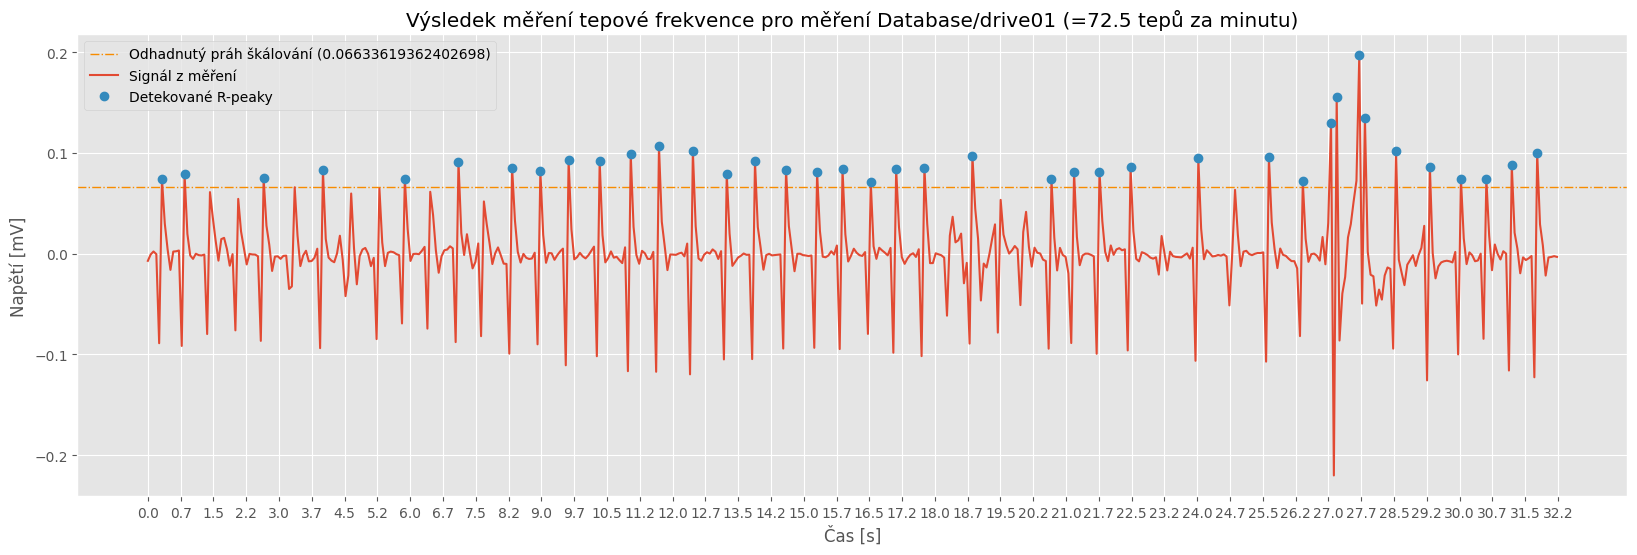

In [4]:
for path in database:
    if path != "Database/drive01":
        continue
    sig, sinfo = get_data(path=path)
    peaks, peak_values = find_peaks(sig)
    threshold = estimate_threshold(sig)
    plt.figure(figsize=(20,6))
    plt.axhline(threshold, linestyle="-.", lw=1, color="#f78c00", label=f"Odhadnutý práh škálování ({threshold})")
    plt.plot(sig, label="Signál z měření")
    plt.plot(peaks, peak_values, 'o', label='Detekované R-peaky')
    plt.title(f"Výsledek měření tepové frekvence pro měření {path} (={avg_hr(peaks, sinfo['fs'], sinfo['sig_len'])} tepů za minutu)")
    plt.xlabel(f"Čas [s]")
    plt.ylabel("Napětí [mV]")
    plt.xticks(np.arange(0, len(sig), 60*3/sinfo["fs"]), np.round(np.arange(0, len(sig), 60*3/sinfo["fs"]) / sinfo["fs"], 1))
    plt.legend(loc="upper left")

In [5]:
percentages = []
import os
for file in os.listdir("nsrdb"):
    if not file.endswith(".dat"):
        continue  

    file = os.path.join("nsrdb", file.replace(".dat", ""))
    correct, wrong, total, detected_total = test_peak_detection(file)
    percent = correct / total
    percentages.append(percent)

    msg = "%s: úspěšnost: %.3f %%, D správně: %s, D špatně: %s, Správně celkem: %s, D celkem: %s" % (
        file, percent*100, correct, wrong, total, detected_total)
    print(msg)
    
print("Půměrná úspěšnost: %.3f %%" % (np.average(percentages)*100))

nsrdb\16265: úspěšnost: 87.472 %, D správně: 1152, D špatně: 759, Správně celkem: 1317, D celkem: 1911
nsrdb\16272: úspěšnost: 84.654 %, D správně: 844, D špatně: 1583, Správně celkem: 997, D celkem: 2427
nsrdb\16273: úspěšnost: 81.014 %, D správně: 1007, D špatně: 882, Správně celkem: 1243, D celkem: 1889
nsrdb\16420: úspěšnost: 78.769 %, D správně: 909, D špatně: 947, Správně celkem: 1154, D celkem: 1856
nsrdb\16483: úspěšnost: 79.419 %, D správně: 930, D špatně: 1362, Správně celkem: 1171, D celkem: 2292
nsrdb\16539: úspěšnost: 94.612 %, D správně: 1036, D špatně: 1151, Správně celkem: 1095, D celkem: 2187
nsrdb\16773: úspěšnost: 59.382 %, D správně: 826, D špatně: 914, Správně celkem: 1391, D celkem: 1740
nsrdb\16786: úspěšnost: 78.216 %, D správně: 754, D špatně: 1066, Správně celkem: 964, D celkem: 1820
nsrdb\16795: úspěšnost: 71.766 %, D správně: 760, D špatně: 1080, Správně celkem: 1059, D celkem: 1840
nsrdb\17052: úspěšnost: 78.712 %, D správně: 880, D špatně: 728, Správně cel

Lowest value in correlation matrix: 0.0005511970034773568
Corresponding labels: ('Database/drive01', 'Database/drive13')

Highest value in correlation matrix: 0.2852113485316801
Corresponding labels: ('Database/drive05', 'Database/drive17b')


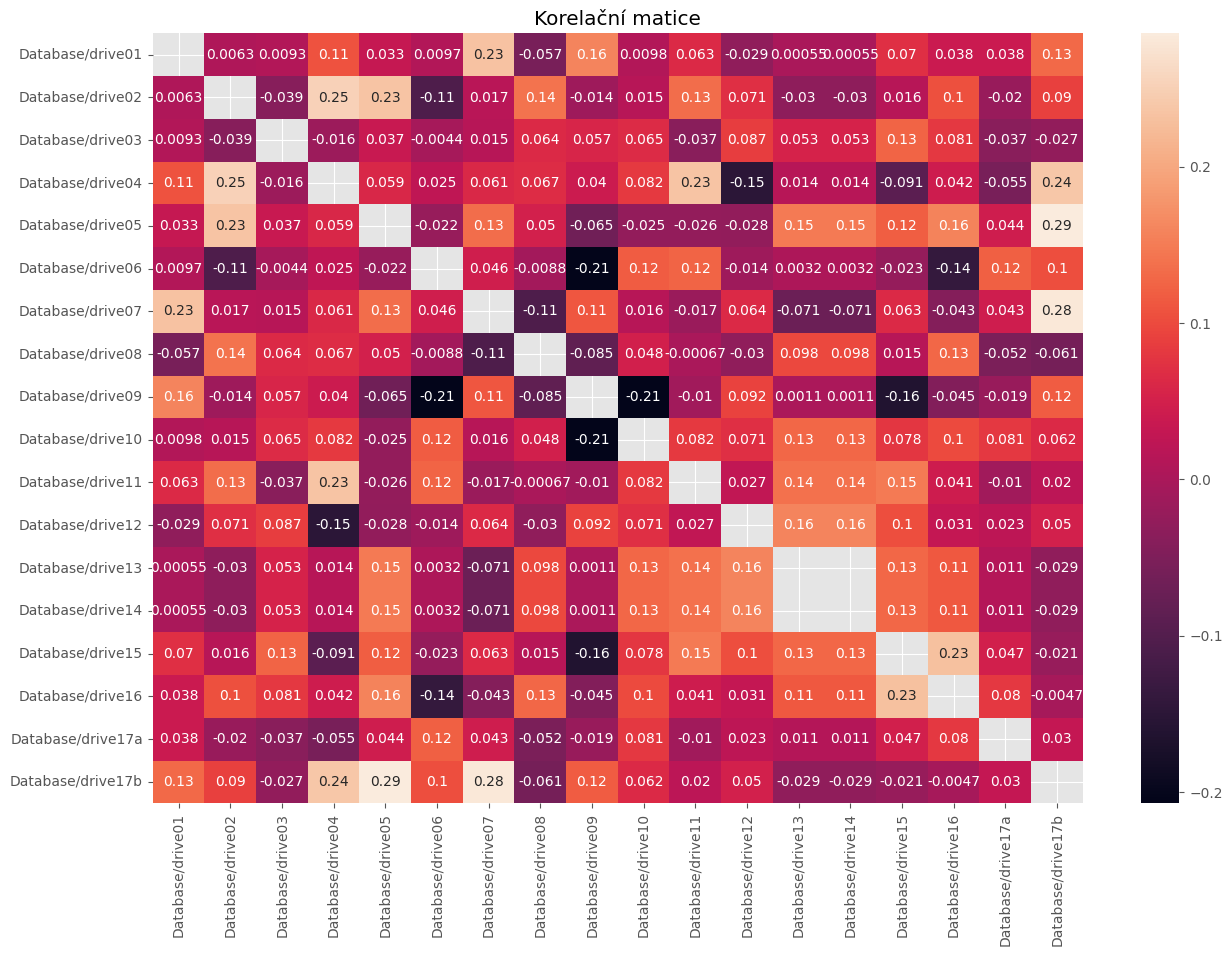

In [6]:
sigs = []
srs = []

for path in database:
    sig, sinfo = get_data(path, hpf=False)
    sigs.append(sig)
    srs.append(sinfo['fs'])
    

sigs, sr, size = pair_signals(sigs, srs)
sigs = np.array(sigs)

cor_matrix = np.corrcoef(sigs)
cor_matrix[np.round(cor_matrix, 4) == 1] = np.nan

min_value = np.nanmin(abs(cor_matrix))
max_value = np.nanmax(abs(cor_matrix))

# Find the indices of the minimum and maximum values
min_index = np.unravel_index(np.nanargmin(abs(cor_matrix)), cor_matrix.shape)
max_index = np.unravel_index(np.nanargmax(abs(cor_matrix)), cor_matrix.shape)

# Get the corresponding labels
min_labels = (database[min_index[0]], database[min_index[1]])
max_labels = (database[max_index[0]], database[max_index[1]])

print("Lowest value in correlation matrix:", min_value)
print("Corresponding labels:", min_labels)

print("\nHighest value in correlation matrix:", max_value)
print("Corresponding labels:", max_labels)

plt.figure(figsize=(15, 10))
plt.title("Korelační matice")

sns.heatmap(cor_matrix, annot=True,
           xticklabels=database,
           yticklabels=database,
           )
plt.show()

(4, 17)


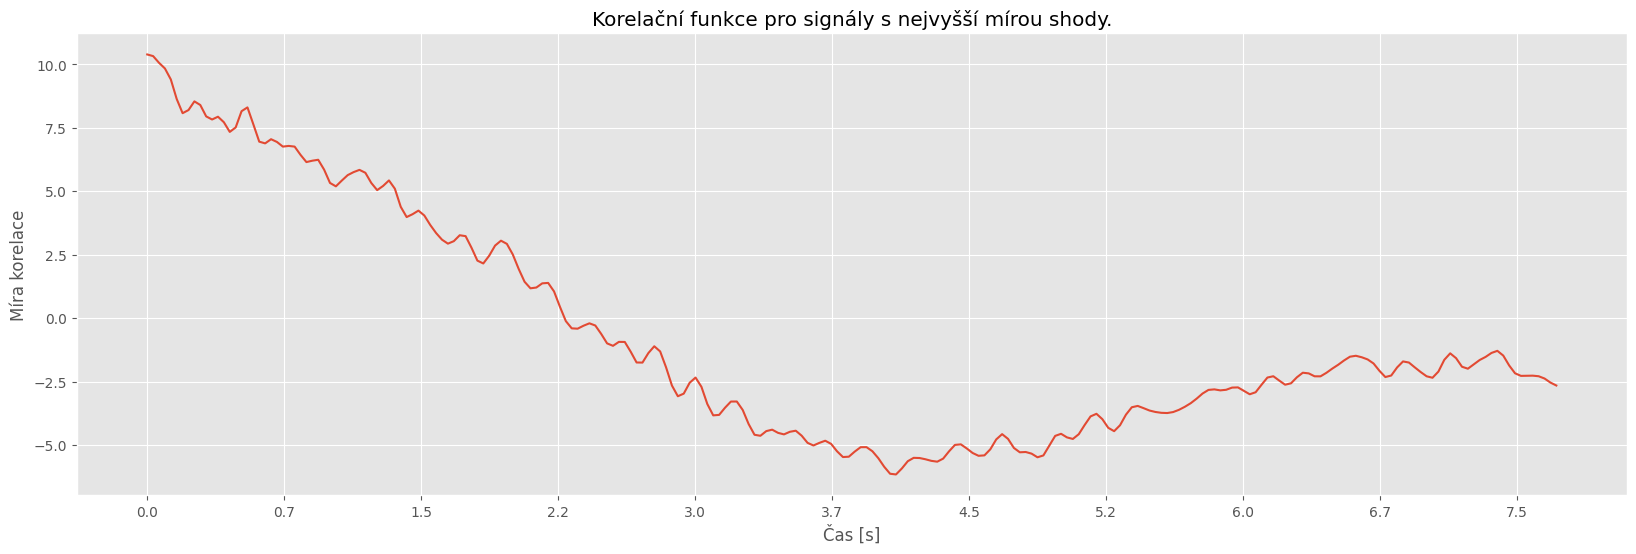

In [11]:
# Greatest correlation drives CF
print(max_index)
s1 = sigs[max_index[0]]
s2 = sigs[max_index[1]]

CF = scipy.signal.correlate(s1, s2, mode="same")
CF = np.array_split(CF,2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(CF)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(s1)//2, 60*12/sr), np.round(np.arange(0, len(s1)//2, 60*12/sr) / sr, 1))
plt.show()

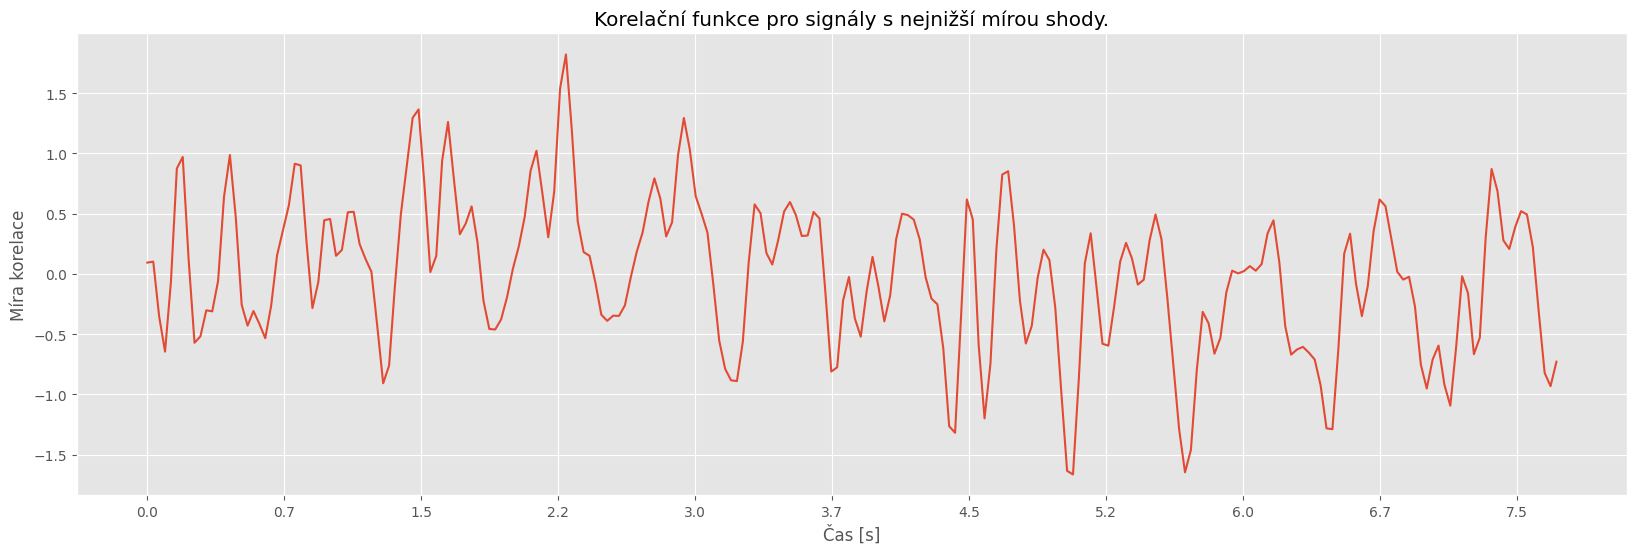

In [12]:
# Lowest correlation drives CF

s1 = sigs[min_index[0]]
s2 = sigs[min_index[1]]

CF = scipy.signal.correlate(s1, s2, mode="same")
CF = np.array_split(CF,2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejnižší mírou shody.")
plt.plot(CF)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(s1)//2, 60*12/sr), np.round(np.arange(0, len(s1)//2, 60*12/sr) / sr, 1))
plt.show()

In [9]:
for path in database:
    sig, sinfo = get_data(path, channels=[1], hpf=False)
    
    print(f"{path} iEMG: {round(np.sum(rectify(sig)), 3)}")

Database/drive01 iEMG: 3.896
Database/drive02 iEMG: 824.877
Database/drive03 iEMG: 539.356
Database/drive04 iEMG: 9291.2
Database/drive05 iEMG: 145.136
Database/drive06 iEMG: 142.203
Database/drive07 iEMG: 30.065
Database/drive08 iEMG: 127.498
Database/drive09 iEMG: 205.335
Database/drive10 iEMG: 153.72
Database/drive11 iEMG: 143.12
Database/drive12 iEMG: 125.404
Database/drive13 iEMG: 486.635
Database/drive14 iEMG: 486.635
Database/drive15 iEMG: 230.405
Database/drive16 iEMG: 218.171
Database/drive17a iEMG: 102.151
Database/drive17b iEMG: 127.089


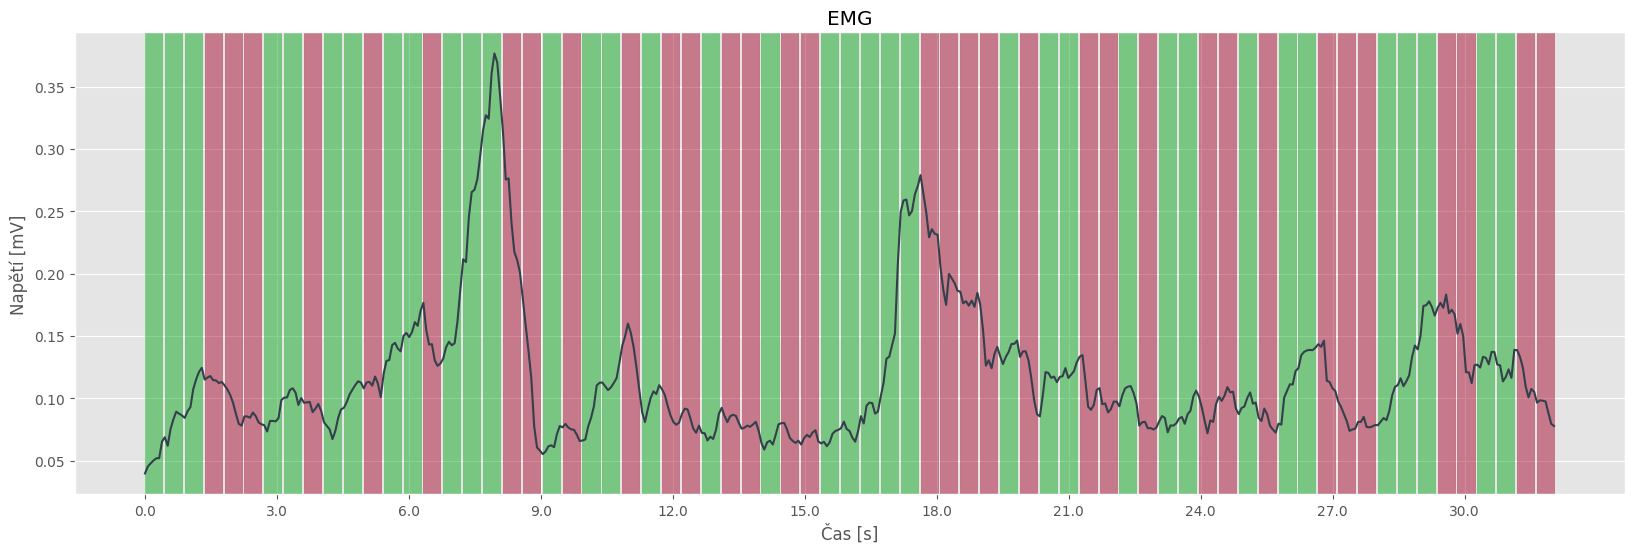

In [10]:
sig, sinfo = get_data("Database/drive01", channels=[1], hpf=False)

remg = rectify(sig)
# Integrate
iremg = integrate(remg, int(sinfo['fs']))

plt.figure(figsize=(20, 6))
plt.title("EMG")
_ = detect_changes(iremg, int(sinfo['fs']/2), do_plot=True)
plt.ylabel("Napětí [mV]")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(sig), 60*12/sinfo['fs']), np.round(np.arange(0, len(sig), 60*12/sinfo['fs']) / sinfo['fs'], 1))
plt.show()